In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import stock
import base_analysis
import return_analysis as ra
import itertools
import scipy.stats as scs
from importlib import reload
from sklearn.linear_model import LinearRegression
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# INTC

In [2]:
reload(stock)
reload(base_analysis)
reload(ra)

<module 'return_analysis' from '/Users/ryohayama/python/DowJones/return_analysis.py'>

<b>Load data</b>

In [3]:
intc = stock.Stock('./stocks/INTC.csv')

In [4]:
intc_ra = ra.ReturnAnalysis(intc, windows=[1, 5, 10, 20, 50, 100, 200])

In [5]:
intc_ra.print_info()

============ ./stocks/INTC Basic Info ============
Start Date - 1980-03-17
 End  Date - 2017-12-22
Number of data points - 9528
Number of missing data points - 0


In [6]:
intc_ra._window_labels_all

['-200day_return',
 '-100day_return',
 '-50day_return',
 '-20day_return',
 '-10day_return',
 '-5day_return',
 '-1day_return',
 '+1day_return',
 '+5day_return',
 '+10day_return',
 '+20day_return',
 '+50day_return',
 '+100day_return',
 '+200day_return']

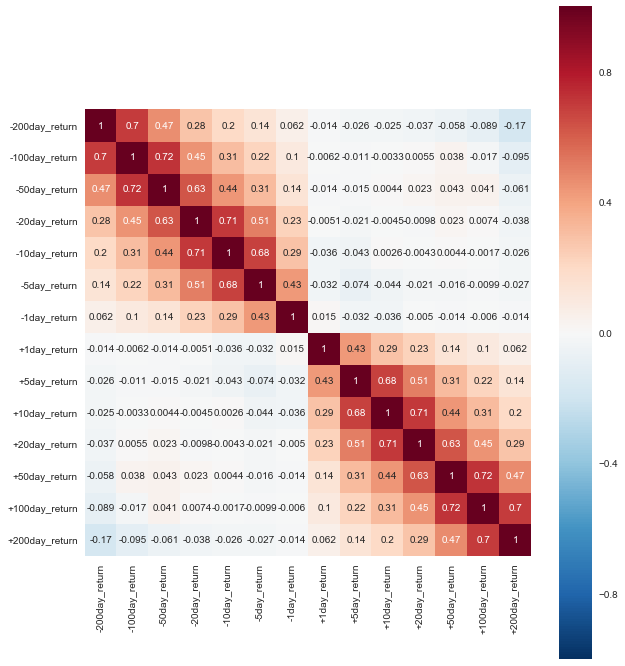

In [7]:
a1 = intc_ra.all_correlations()
plt.figure(figsize=(10,12))
sns.heatmap(a1, vmin=-1, vmax=1, square=True, annot=True)

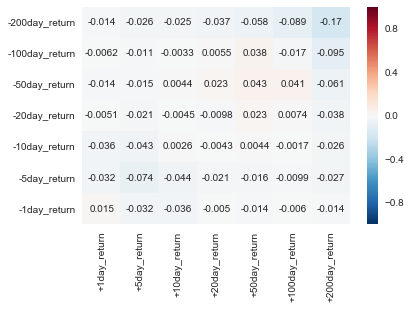

In [8]:
a2 = intc_ra.current_future_correlations()
sns.heatmap(a2, vmin=-1, vmax=1, annot=True)

## Testing Differential distribution of shorter-term returns
Approach:<br>
First, classify the data into subsets (i.e. pick up a subset of dates & their returns that meet a certain criteria) based on the <i>future</i> longer-term returns (LTRs). Here, LTRs were classified into 6 different classes based on the deviation from the mean return. Basically, these subsets select dates whose future returns are of certain levels. Then, <i>current</i> shorter-term returns (STRs) were also subsetted based on the LTR-subset dates. Distribution of STRs for those subsets were compared among each other to see if there are differential distributions among STR subsets that yield differential LTRs. In other words, the question here is "Does the XX-day return up to today correlated with YY-day return in the future?"

<b>Create data for +/- 1, 5, and 10 day returns</b>

In [9]:
return_1c = intc_ra.data['-1day_return']
return_5c = intc_ra.data['-5day_return']
return_10c = intc_ra.data['-10day_return']

return_1f = intc_ra.data['+1day_return']
return_5f = intc_ra.data['+5day_return']
return_10f = intc_ra.data['+10day_return']

<b>Classify 1-day return based on 5-day returns</b>

In [10]:
d5 = return_5f
deviation_levels_5 = {}
mean5 = d5.mean()
std5 = d5.std()
level_1 = mean5 - 2*std5
level_2 = mean5 - std5
level_3 = mean5
level_4 = mean5 + std5
level_5 = mean5 + 2*std5
deviation_levels_5['lowest'] = list(d5[d5 <= level_1].index)
deviation_levels_5['lower'] = list(d5[(d5 > level_1) & (d5 <= level_2)].index)
deviation_levels_5['low'] = list(d5[(d5 > level_2) & (d5 <= level_3)].index)
deviation_levels_5['high'] = list(d5[(d5 > level_3) & (d5 <= level_4)].index)
deviation_levels_5['higher'] = list(d5[(d5 > level_4) & (d5 <= level_5)].index)
deviation_levels_5['highest'] = list(d5[d5 > level_5].index)

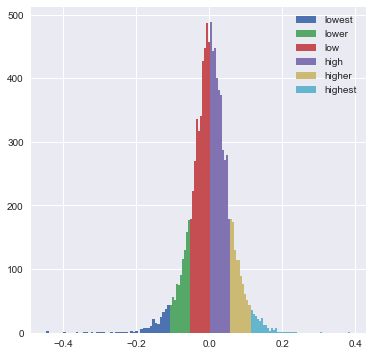

In [11]:
# Verify classification by plotting subsets
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
d5[deviation_levels_5['lowest']].hist(ax=ax1, bins=50, label='lowest')
d5[deviation_levels_5['lower']].hist(ax=ax1, label='lower')
d5[deviation_levels_5['low']].hist(ax=ax1, label='low')
d5[deviation_levels_5['high']].hist(ax=ax1, label='high')
d5[deviation_levels_5['higher']].hist(ax=ax1, label='higher')
d5[deviation_levels_5['highest']].hist(ax=ax1, bins=50, label='highest')
ax1.legend()

In [12]:
d1_lowest5 = return_1c[deviation_levels_5['lowest']]
d1_lower5 = return_1c[deviation_levels_5['lower']]
d1_low5 = return_1c[deviation_levels_5['low']]
d1_high5 = return_1c[deviation_levels_5['high']]
d1_higher5 = return_1c[deviation_levels_5['higher']]
d1_highest5 = return_1c[deviation_levels_5['highest']]

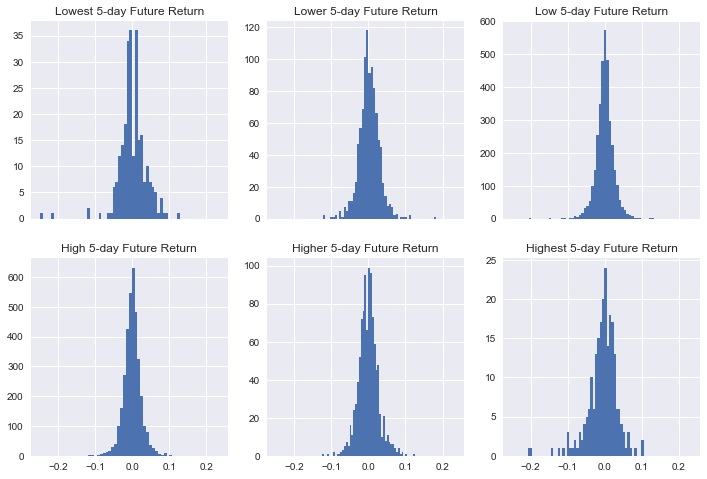

In [13]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=False)
d1_lowest5.hist(ax=ax1, bins=50, label='lowest')
d1_lower5.hist(ax=ax2, bins=50, label='lower')
d1_low5.hist(ax=ax3, bins=50, label='low')
d1_high5.hist(ax=ax4, bins=50, label='high')
d1_higher5.hist(ax=ax5, bins=50, label='higher')
d1_highest5.hist(ax=ax6, bins=50, label='highest')
ax1.set_title('Lowest 5-day Future Return')
ax2.set_title('Lower 5-day Future Return')
ax3.set_title('Low 5-day Future Return')
ax4.set_title('High 5-day Future Return')
ax5.set_title('Higher 5-day Future Return')
ax6.set_title('Highest 5-day Future Return')

In [14]:
d1_list = [d1_lowest5, d1_lower5, d1_low5, d1_high5, d1_higher5, d1_highest5]
labels = ['Lowest', 'Lower', 'Low', 'High', 'Higher', 'Highest']
df = pd.DataFrame(columns=labels, index=labels)
for i in range(6):
    for j in range(6):
        df.iloc[i, j] =  scs.ks_2samp(d1_list[i], d1_list[j])[1]
df = df.astype('float')

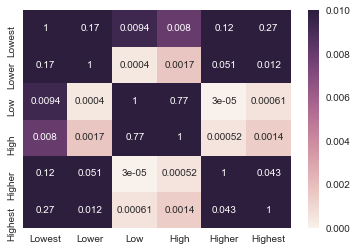

In [15]:
sns.heatmap(df, vmin=0, vmax=0.01, annot=True)

In [16]:
print("===== 1-day return classed on 5-day return =====")
print("Lowest vs Lower  : pval=%.3f" % scs.ks_2samp(d1_lowest5, d1_lower5)[1])
print("Lowest vs Low    : pval=%.3f" % scs.ks_2samp(d1_lowest5, d1_low5)[1])
print("Lowest vs High   : pval=%.3f" % scs.ks_2samp(d1_lowest5, d1_high5)[1])
print("Lowest vs Higher : pval=%.3f" % scs.ks_2samp(d1_lowest5, d1_higher5)[1])
print("Lowest vs Highest: pval=%.3f" % scs.ks_2samp(d1_lowest5, d1_highest5)[1])
print("Lower vs Low     : pval=%.3f" % scs.ks_2samp(d1_lower5, d1_low5)[1])
print("Lower vs High    : pval=%.3f" % scs.ks_2samp(d1_lower5, d1_high5)[1])
print("Lower vs Higher  : pval=%.3f" % scs.ks_2samp(d1_lower5, d1_higher5)[1])
print("Lower vs Highest : pval=%.3f" % scs.ks_2samp(d1_lower5, d1_highest5)[1])
print("Low vs High      : pval=%.3f" % scs.ks_2samp(d1_low5, d1_high5)[1])
print("Low vs Higher    : pval=%.3f" % scs.ks_2samp(d1_low5, d1_higher5)[1])
print("Low vs Highest   : pval=%.3f" % scs.ks_2samp(d1_low5, d1_highest5)[1])
print("High vs Higher   : pval=%.3f" % scs.ks_2samp(d1_high5, d1_higher5)[1])
print("High vs Highest  : pval=%.3f" % scs.ks_2samp(d1_high5, d1_highest5)[1])
print("Higher vs Highest: pval=%.3f" % scs.ks_2samp(d1_higher5, d1_highest5)[1])

===== 1-day return classed on 5-day return =====
Lowest vs Lower  : pval=0.167
Lowest vs Low    : pval=0.009
Lowest vs High   : pval=0.008
Lowest vs Higher : pval=0.122
Lowest vs Highest: pval=0.269
Lower vs Low     : pval=0.000
Lower vs High    : pval=0.002
Lower vs Higher  : pval=0.051
Lower vs Highest : pval=0.012
Low vs High      : pval=0.766
Low vs Higher    : pval=0.000
Low vs Highest   : pval=0.001
High vs Higher   : pval=0.001
High vs Highest  : pval=0.001
Higher vs Highest: pval=0.043


<b>So does this mean that ends are similar to each other while they're different from middle ones? In other words, the 1-day return that give mean +/- 1*std return in 5 days are differently distributed than the 1-day return that yield mean +/- 1*std or more in 5-day return?</b>

<b>Classify 1-day return based on 10-day returns</b>

In [17]:
d10 = return_10f
deviation_levels_10 = {}
mean10 = d10.mean()
std10 = d10.std()
level_1 = mean10 - 2*std10
level_2 = mean10 - std10
level_3 = mean10
level_4 = mean10 + std10
level_5 = mean10 + 2*std10
deviation_levels_10['lowest'] = list(d10[d10 <= level_1].index)
deviation_levels_10['lower'] = list(d10[(d10 > level_1) & (d10 <= level_2)].index)
deviation_levels_10['low'] = list(d10[(d10 > level_2) & (d10 <= level_3)].index)
deviation_levels_10['high'] = list(d10[(d10 > level_3) & (d10 <= level_4)].index)
deviation_levels_10['higher'] = list(d10[(d10 > level_4) & (d10 <= level_5)].index)
deviation_levels_10['highest'] = list(d10[d10 > level_5].index)

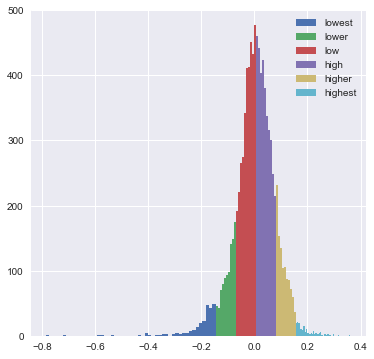

In [18]:
# Verify classification by plotting subsets
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
d10[deviation_levels_10['lowest']].hist(ax=ax1, bins=50, label='lowest')
d10[deviation_levels_10['lower']].hist(ax=ax1, label='lower')
d10[deviation_levels_10['low']].hist(ax=ax1, label='low')
d10[deviation_levels_10['high']].hist(ax=ax1, label='high')
d10[deviation_levels_10['higher']].hist(ax=ax1, label='higher')
d10[deviation_levels_10['highest']].hist(ax=ax1, bins=50, label='highest')
ax1.legend()

In [19]:
d1_lowest10 = return_1c[deviation_levels_10['lowest']]
d1_lower10 = return_1c[deviation_levels_10['lower']]
d1_low10 = return_1c[deviation_levels_10['low']]
d1_high10 = return_1c[deviation_levels_10['high']]
d1_higher10 = return_1c[deviation_levels_10['higher']]
d1_highest10 = return_1c[deviation_levels_10['highest']]

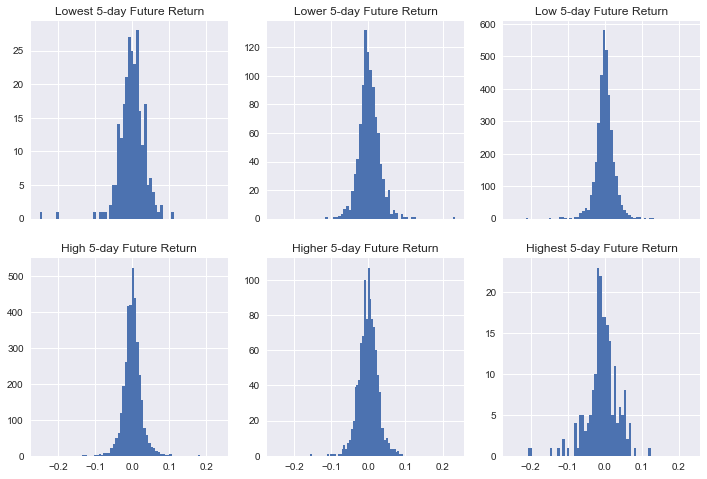

In [20]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=False)
d1_lowest10.hist(ax=ax1, bins=50, label='lowest')
d1_lower10.hist(ax=ax2, bins=50, label='lower')
d1_low10.hist(ax=ax3, bins=50, label='low')
d1_high10.hist(ax=ax4, bins=50, label='high')
d1_higher10.hist(ax=ax5, bins=50, label='higher')
d1_highest10.hist(ax=ax6, bins=50, label='highest')
ax1.set_title('Lowest 5-day Future Return')
ax2.set_title('Lower 5-day Future Return')
ax3.set_title('Low 5-day Future Return')
ax4.set_title('High 5-day Future Return')
ax5.set_title('Higher 5-day Future Return')
ax6.set_title('Highest 5-day Future Return')

In [21]:
d1_list10 = [d1_lowest10, d1_lower10, d1_low10, d1_high10, d1_higher10, d1_highest10]
labels = ['Lowest', 'Lower', 'Low', 'High', 'Higher', 'Highest']
df2 = pd.DataFrame(columns=labels, index=labels)
for i in range(6):
    for j in range(6):
        df2.iloc[i, j] =  scs.ks_2samp(d1_list10[i], d1_list10[j])[1]
df2 = df2.astype('float')

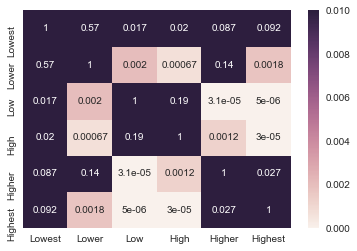

In [22]:
sns.heatmap(df2, vmin=0, vmax=0.01, annot=True)